# Log process

## init

### libs

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import datetime
import re
import IPython.display # use within function as IPython.display.display(dataFrame)

#settings
import matplotlib
matplotlib.rcParams['figure.dpi'] = 80

### css

In [2]:
%%html
<style>
div.jp-MarkdownOutput h1,
div.text_cell_render h1 {
    color: #404040;
    font-size: 38pt;
}

div.jp-MarkdownOutput h2,
div.text_cell_render h2 {
    color: #696969;
    font-size: 28pt;
}
div.jp-MarkdownOutput h3,
div.text_cell_render h3 {
    color: brown;
    font-size: 24pt;
}
div.jp-MarkdownOutput h4,
div.text_cell_render h4 {
    color: navy;
    font-size: 16pt;
}
div.jp-MarkdownOutput h5,
div.text_cell_render h5 {
    font-size: 14pt;
}
div.jp-MarkdownOutput h6,
div.text_cell_render h6 {
    font-size: 14pt;
    color: #696969;
}

div.jp-MarkdownOutput h3,
div.jp-MarkdownOutput h4,
div.jp-MarkdownOutput h5,
div.jp-MarkdownOutput h6,
div.text_cell_render h3,
div.text_cell_render h4,
div.text_cell_render h5,
div.text_cell_render h6 {
    font-weight: 300;
}



.container { width:99% !important; }
.rendered_html img{
    margin-left: 1px;
    display: inline-block;
}
.rendered_html table{
    margin-left: 1px;
    display: inline-block;
}


/* remove the run cell button */
.code_cell .run_this_cell {
    visibility: hidden;
    cursor: pointer;
    color: #333;
    padding-top: 0px;
    padding-bottom: 0px;
    padding-left: 0ex;
    padding-right: 0ex;
    width: 0ex;
}
@media not all, (any-pointer: coarse)
.code_cell.selected .run_this_cell {
    visibility: visible;
}

/* remove pilcrow */
.anchor-link{
    font-size: 0;
</style>

## log process

### import

In [3]:
def lok():
    df = pd.read_csv("./log.csv")
    df["start"] = pd.to_datetime(df["start"]) # convert date stamps to time-objects
    df["end"] = pd.to_datetime(df["end"])
    df["seconds"] = (df["end"]-df["start"]).astype('timedelta64[s]')
    df = df.sort_values(by=['start']).reset_index(drop=True)
    df.index = df["start"]
    return df.copy()
data = {} # init global data dict
data["log"] = lok() # store log data into data dict

### accumulate hours

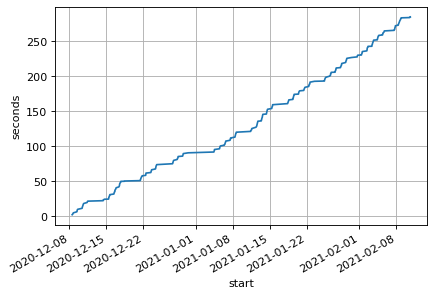

In [28]:
def lok(divide_seconds = 3600):
    
    df = data["log"].copy()
    fig, ax = plt.subplots()
    plt.plot_date(df["start"], df["seconds"].cumsum()/divide_seconds, linestyle="-", marker=None)
    fig.autofmt_xdate()
    #ax.set_xlim([datetime.date(2015, 1, 1), datetime.date(2021, 1, 1)])
    ax.set_xlabel("start")
    ax.set_ylabel("seconds")
    ax.grid()
    plt.show()
lok()

### shift length

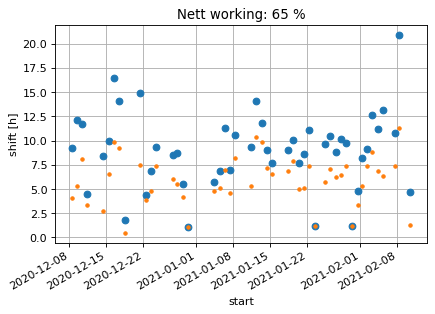

In [34]:
def lok(divide_seconds = 3600):
    
    df0 = data["log"].copy() # untouched
    df1 = data["log"].copy() # daily start
    df2 = data["log"].copy() # daily end
    df3 = data["log"].copy() # daily net work
    # new index to operate on
    df1["si"] = df1["start"] # si = start-index
    df2["si"] = df2["start"] # si = start-index
    df1.set_index("si")
    df2.set_index("si")
    # shift start
    df1 = df1.groupby(pd.Grouper(freq='D')).first().dropna()
    #shift end
    df2 = df2.groupby(pd.Grouper(freq='D')).last().dropna()
    #shift duration
    df1["shift"] = (df2["end"] - df1["start"]).astype('timedelta64[s]')
    #shift end
    #df3 = df3.resample("D").sum().reset_index()
    df3 = df3.groupby(pd.Grouper(freq='D')).sum()#.dropna()
    df3 = df3[(df3.T != 0).any()] # remove 0
    df3["hours"] = df3["seconds"]/divide_seconds
    
    # overview columns
    df1["hshift"] = df1["shift"]/3600.0
    df1["hnett"] = df3["seconds"]/divide_seconds
    df1["rwork"] = df3["seconds"]/df1["shift"]
    
    #plot
    fig, ax = plt.subplots()
    ax.plot_date(df1["start"], df1["shift"]/divide_seconds, linestyle="", marker="o")
    ax.plot_date(df1["start"], df3["seconds"]/divide_seconds, linestyle="", marker=".")
    fig.autofmt_xdate()
    ax.set_xlabel("start")
    ax.set_ylabel("shift [h]")
    ax.grid()
    percent = df0["seconds"].sum()/df1["shift"].sum() * 100
    percent = round(percent,0)
    ax.set_title("Nett working: "+ '{:n}'.format(percent) + " %")
    plt.show()
    df1["hshift"] = df1["shift"]/3600.0
    #IPython.display.display(df1.tail())
    
lok()
    

rwork - relative nett work  
hnett - nett hours  
hshift - shift length in hours  

### nett hours by day

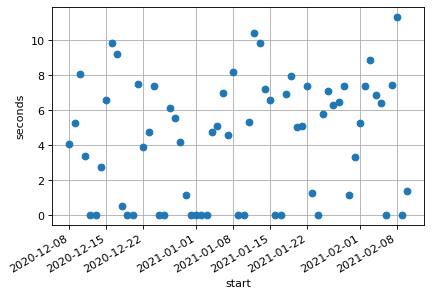

In [35]:
def lok(divide_seconds = 3600):
    
    df = data["log"].copy()
    #df = df.resample("D").sum().drop("stanje",axis=1).copy().reset_index() #https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects
    df = df.resample("D").sum().reset_index() #https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects
    fig, ax = plt.subplots()
    plt.plot_date(df["start"], df["seconds"]/divide_seconds, linestyle="", marker="o")
    fig.autofmt_xdate()
    #ax.set_xlim([datetime.date(2015, 1, 1), datetime.date(2021, 1, 1)])
    ax.set_xlabel("start")
    ax.set_ylabel("hours")
    ax.grid()
    plt.show()
    df["hours"] = df["seconds"]/divide_seconds
    #IPython.display.display(df.tail())
lok()
    

### weekly nett hours

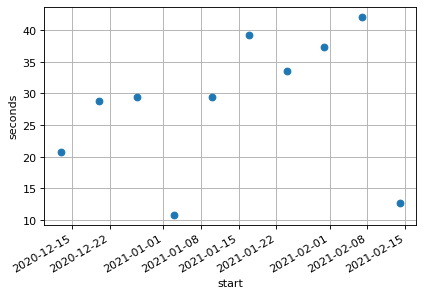

In [31]:
def lok(divide_seconds = 3600):
    
    df = data["log"].copy()
    #df = df.resample("D").sum().drop("stanje",axis=1).copy().reset_index() #https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects
    df = df.resample("W").sum().reset_index() #https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects
    fig, ax = plt.subplots()
    plt.plot_date(df["start"], df["seconds"]/divide_seconds, linestyle="", marker="o")
    fig.autofmt_xdate()
    #ax.set_xlim([datetime.date(2015, 1, 1), datetime.date(2021, 1, 1)])
    ax.set_xlabel("start")
    ax.set_ylabel("seconds")
    ax.grid()
    plt.show()
lok()
    

### punch card

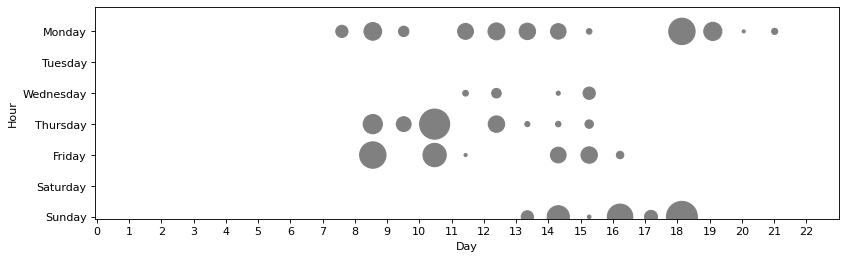

In [24]:
def lok():
    # source https://gist.github.com/rgiot/4943850
    # Discussion http://stackoverflow.com/questions/14849815/matplotlib-how-to-remove-the-vertical-space-when-displaying-circles-on-a-grid
    def draw_punchcard(infos,
                    ax1=range(7),
                    ax2=range(24),
                    ax1_ticks=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                    ax2_ticks=range(24),
                    ax1_label='Day',
                    ax2_label='Hour'):
        """Construct a punchcard.
        Quick'n dirty way.
        Parameters
        ==========
        - infos: Dictionary of quantities to display.
                They are indexed by key of type (val1,val2) with
                val1 included in ax1 and val2 included in ax2.
        - ax1: list
                Possible values for first axe (if different than days)
        - ax2: list
                Possible values for second axe (if different than hours)
        - ax1_ticks: list
                Value to display in ticks of first axe (if different than days)
        - ax2_ticks: list
                Value to display in ticks of second axe (if different than days)
        - ax1_label: String
                Value to give to first axis (if different than day)
        - ax2_label: String
                Value to give to second axis (if different than day)
        """

        # build the array which contains the values
        data = np.zeros((len(ax1),len(ax2)))
        for key in infos:
            data[key[0],key[1]] = infos[key]
        data_ax1 = np.sum(data, axis=1)
        data_ax2 = np.sum(data, axis=0)
        data_ax1.shape=(-1,1)
        data_ax2.shape=(1,-1)
        data = data/float(np.max(data))
        data_ax1 = data_ax1/float(np.max(data_ax1))
        data_ax2 = data_ax2/float(np.max(data_ax2))

        # shape ratio
        r = float(data.shape[1])/data.shape[0]
        # Draw the punchcard (create one circle per element)
        # Ugly normalisation allows to obtain perfect circles instead of ovals....
        for y in range(data.shape[0]):
            for x in range(data.shape[1]):
                circle = plt.Circle((x/float(data.shape[1])*data.shape[0],y/r),
                                    data[y][x]/float(data.shape[1])*data.shape[0]/2,
                                    color='gray')
                plt.gca().add_artist(circle)

        plt.ylim(0-0.5,  data.shape[0]-0.5)
        plt.xlim(0, data.shape[0])
        plt.yticks(np.arange(0,len(ax1)/r-.1,1/r), ax1_ticks)
        plt.xticks(np.linspace(0,len(ax1), len(ax2))+0.5/float(data.shape[1]), ax2_ticks)
        plt.xlabel(ax1_label)
        plt.ylabel(ax2_label)
        plt.gca().invert_yaxis()

        # make sure the axes are equal, and resize the canvas to fit the plot
        plt.axis('equal')
        plt.axis([0, 7.02, 7/r, -.5])
        scale = 0.5
        plt.gcf().set_size_inches(data.shape[1]*scale,data.shape[0]*scale, forward=True)


        
    dfp = data["log"].copy()
    dfp = dfp.resample("H").sum().reset_index() #https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects
    dfp = dfp.dropna()
    dfp["hour"] = dfp.start.dt.hour
    dfp["weekday"] = dfp.start.dt.weekday
    #return data["log"].start.dt.weekday
    #return data["log"].start.dt.hour
    
    infos = {}
    for index, row in dfp.iterrows():
        infos[(row["weekday"], row["hour"])] = row["seconds"]        
    
    draw_punchcard(infos)
    plt.show()
lok()

### weekly hours by task

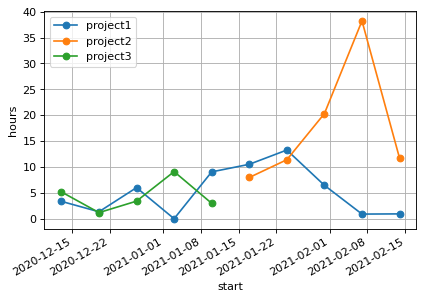

In [32]:
def lok(divide_seconds = 3600):
    def my_task(task):
        df = data["log"].copy()
        df = df[df["task"].str.contains(task , flags=re.IGNORECASE, regex=True)]
        #df = df.resample("D").sum().drop("stanje",axis=1).copy().reset_index() #https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects
        return df.resample("W").sum().reset_index().copy() #https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects
    
    project1 = my_task("project1")
    project2 = my_task("project2")
    project3 = my_task("project3")
    
    fig, ax = plt.subplots()
    plt.plot_date(project1["start"], project1["seconds"]/divide_seconds, linestyle="-", marker="o", label="project1")
    plt.plot_date(project2["start"], project2["seconds"]/divide_seconds, linestyle="-", marker="o", label="project2")
    plt.plot_date(project3["start"], project3["seconds"]/divide_seconds, linestyle="-", marker="o", label="project3")
    fig.autofmt_xdate()
    #ax.set_xlim([datetime.date(2015, 1, 1), datetime.date(2021, 1, 1)])
    ax.set_xlabel("start")
    ax.set_ylabel("hours")
    ax.grid()
    ax.legend()
    plt.show()
lok()
    

### monthly hours by task

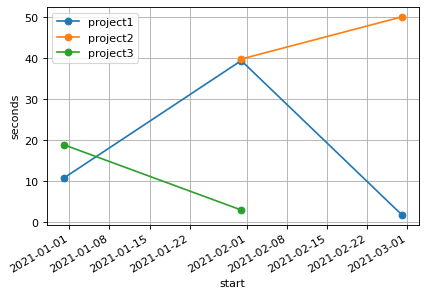

In [33]:
def lok(divide_seconds = 3600):
    def my_task(task):
        df = data["log"].copy()
        df = df[df["task"].str.contains(task , flags=re.IGNORECASE, regex=True)]
        #df = df.resample("D").sum().drop("stanje",axis=1).copy().reset_index() #https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects
        return df.resample("M").sum().reset_index().copy() #https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects
    
    project1 = my_task("project1")
    project2 = my_task("project2")
    project3 = my_task("project3")
    
    fig, ax = plt.subplots()
    plt.plot_date(project1["start"], project1["seconds"]/divide_seconds, linestyle="-", marker="o", label="project1")
    plt.plot_date(project2["start"], project2["seconds"]/divide_seconds, linestyle="-", marker="o", label="project2")
    plt.plot_date(project3["start"], project3["seconds"]/divide_seconds, linestyle="-", marker="o", label="project3")
    fig.autofmt_xdate()
    #ax.set_xlim([datetime.date(2015, 1, 1), datetime.date(2021, 1, 1)])
    ax.set_xlabel("start")
    ax.set_ylabel("seconds")
    ax.grid()
    ax.legend()
    plt.show()
lok()
    